In [217]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from preproc import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

In [218]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181101"

In [219]:
# Save directory for figures and data files
figsave_dir = f'figures/{day_dir}/timebinned'
datasave_dir = f'data/timebinned'

### Preprocessing of rplparallel, spiketrain, vmpv, raycast data

In [220]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp_file = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp_file.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.round(np.array(rp.get('timeStamps')), 3)
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)
rp_file.close()

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    try:
        spk_file = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except NotImplementedError:
        spk_file = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except FileNotFoundError:
        continue
    spk = np.array(spk_file.get('timestamps')).flatten() # spike timestamps is loaded in as a column vector
    spk /= 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    if isinstance(spk_file, h5py.File):
        spk_file.close()
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv_file = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv_file.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)
pv_file.close()

# Load data from binData.hdf object, extract view bin data
viewbin_data = np.genfromtxt(prefix + day_dir + "/session01/1binData.csv", delimiter=',')
viewbin_data[:,0] /= 1000 # convert eyelink timestamps from msec to sec

# Load dat from eyelink.mat object, extract fixation times, eye positions and eyelink trial timestamps
el = h5py.File(prefix + day_dir + "/session01/eyelink.mat")
el = el.get('el').get('data')
el_trial_timestamps = np.array(el.get('trial_timestamps'))
el_fix_times = np.array(el.get('fix_times'))

In [221]:
# Define important constants
num_cells = len(cell_labels)
num_goals = 6
tbin_size = 0.1
time_res = 0.001

In [222]:
# Get trial outcomes from trial markers
# 0 for unsuccessful trials, 1 for successful trials
trial_outcomes = 4 - trial_markers[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]

# Formatting
trial_timestamps = trial_timestamps.T
el_trial_timestamps = el_trial_timestamps.T
el_fix_times = el_fix_times.T

In [223]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_outcomes = trial_outcomes[trial_filt]
trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt]
nav_intervals = nav_intervals[trial_filt]
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
trial_trajectories = trial_trajectories[trial_filt]
trial_timestamps = trial_timestamps[trial_filt]
el_trial_timestamps = el_trial_timestamps[trial_filt]

Extract fixation events from raw eyelink data

In [224]:
# Some functions for working with raw eyelink data
def find_floor(arr, x):
    for i, val in enumerate(arr):
        if x < val:
            return i-1
    return len(arr)-1
    
def find_ceil(arr, x):
    for i, val in enumerate(arr):
        if x <= val:
            return i
    return -1

# Convert eyelink time to trial time for cue phase
def convert_eyelink_time_cue(trial, intvls):
    res = np.empty_like(intvls)
    for i, intvl in enumerate(intvls):
        st, ed = intvl
        el_st, el_ed = el_trial_timestamps[trial,:2]
        t_st, t_ed = trial_timestamps[trial,:2]
        res[i,0] = ((st - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
        res[i,1] = ((ed - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
    return res

# Convert eyelink time to trial time for nav phase
def convert_eyelink_time_nav(trial, intvls):
    res = np.empty_like(intvls)
    for i, intvl in enumerate(intvls):
        st, ed = intvl
        el_st, el_ed = el_trial_timestamps[trial,1:]
        t_st, t_ed = trial_timestamps[trial,1:]
        res[i,0] = ((st - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
        res[i,1] = ((ed - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
    return res

# Get view bin corresponding to a given time stamp
def gaze_loc(time):
    idx = np.searchsorted(viewbin_data[:,0], time)
    return viewbin_data[idx,1]

# Check if at least 50% of the fixation event lies within the desired view bin(s)
def gaze_filter(intvl, cond):
    st_time, ed_time = intvl
    res = list()
    for t in np.arange(st_time, ed_time, time_res):
        if cond(gaze_loc(t)):
            res.append(1)
        else:
            res.append(0)
    return sum(res) >= len(res)/2

# Poster view bin numbers for each poster
poster_viewbins = [set(np.concatenate([np.arange(4701,4704+1), np.arange(4733,4736+1), np.arange(4765,4768+1)])),\
                   set(np.concatenate([np.arange(4997,5000+1), np.arange(5029,5032+1), np.arange(5061,5064+1)])),\
                   set(np.concatenate([np.arange(4533,4536+1), np.arange(4565,4568+1), np.arange(4597,4600+1)])),\
                   set(np.concatenate([np.arange(4845,4848+1), np.arange(4877,4480+1), np.arange(4909,4912+1)])),\
                   set(np.concatenate([np.arange(4861,4864+1), np.arange(4893,4896+1), np.arange(4925,4928+1)])),\
                   set(np.concatenate([np.arange(4685,4688+1), np.arange(4717,4720+1), np.arange(4749,4752+1)]))]

In [225]:
# Extract fixation events in each trial for cue phases and nav phases separately
cue_fixes_per_trial = [np.empty((0,2)) for _ in range(el_trial_timestamps.shape[0])]
nav_fixes_per_trial = [np.empty((0,2)) for _ in range(el_trial_timestamps.shape[0])]

for idx, fix_start in enumerate(el_fix_times[:,0]):
    # Check if it occurs during cue phase of a trial, and which one
    i1 = find_floor(el_trial_timestamps[:,0], fix_start)
    i2 = find_ceil(el_trial_timestamps[:,1], fix_start)
    if i1 == i2:
        # Occurs during a trial
        fix_end = el_fix_times[idx,1]
        cue_fixes_per_trial[i1] = np.vstack([cue_fixes_per_trial[i1], np.array([fix_start, fix_end]).astype(np.int64)])
    
    # Check if it occurs during nav phase of a trial, and which one
    i1 = find_floor(el_trial_timestamps[:,1], fix_start)
    i2 = find_ceil(el_trial_timestamps[:,2], fix_start)
    if i1 == i2:
        # Occurs during a trial
        fix_end = el_fix_times[idx,1]
        nav_fixes_per_trial[i1] = np.vstack([nav_fixes_per_trial[i1], np.array([fix_start, fix_end]).astype(np.int64)])

# Check each fixation event to see if it is on the cue image, filter out non-cue image fixations
cueimg_filter = [np.empty([trial.shape[0]], dtype=bool) for trial in cue_fixes_per_trial]
for i, trial in enumerate(cue_fixes_per_trial):
    if trial.shape[0] == 0:
        continue
    cue_fixes_per_trial[i] = convert_eyelink_time_cue(i, trial)
    for j, event in enumerate(cue_fixes_per_trial[i]):
        st_time, ed_time = event
        cueimg_filter[i][j] = gaze_loc(st_time) == 1
    cue_fixes_per_trial[i] = cue_fixes_per_trial[i][cueimg_filter[i]]

hint_fixes_per_trial = [np.array([]) for _ in range(el_trial_timestamps.shape[0])]
poster_fixes_per_trial = [np.array([]) for _ in range(el_trial_timestamps.shape[0])]
hintimg_filter = [np.empty([trial.shape[0]], dtype=bool) for trial in nav_fixes_per_trial]
poster_filter = [np.empty([trial.shape[0]], dtype=bool) for trial in nav_fixes_per_trial]
for i, trial in enumerate(nav_fixes_per_trial):
    if trial.shape[0] == 0:
        continue
    nav_fixes_per_trial[i] = convert_eyelink_time_nav(i, trial)
    for j, event in enumerate(nav_fixes_per_trial[i]):
        st_time, ed_time = event
        hintimg_filter[i][j] = gaze_loc(st_time) == 2
        poster_filter[i][j] = gaze_loc(st_time) in poster_viewbins[trial_markers[i]-1]
    hint_fixes_per_trial[i] = nav_fixes_per_trial[i][hintimg_filter[i]]
    poster_fixes_per_trial[i] = nav_fixes_per_trial[i][poster_filter[i]]


Cue phase data

In [226]:
# Slot spikes into cue phase, cue image fixation events, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
timebins_cue = [np.hstack([trial[:,0].reshape(-1,1), trial[:,0].reshape(-1,1)+tbin_size]) for trial in cue_fixes_per_trial]
spikerates_cue = list()
for i, trial in enumerate(timebins_cue):
    spikerates_cue.append(np.array(spike_rates_per_observation(trial, spike_times)))

# Flatten cue spike counts/rates into a single long array containing all instances across trials
goals_cue = list()
for i, goal in enumerate(trial_markers):
    goals_cue.extend(spikerates_cue[i].shape[0]*[goal])
goals_cue = np.array(goals_cue)

trajectories_cue = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_cue.extend([traj for _ in range(spikerates_cue[i].shape[0])])

spikerates_cue = np.vstack(spikerates_cue)

In [227]:
'''
# Extract periods in cue phase where cue image was not looked at
# Preallocate list of arrays for spike counts per time bin in cue phase
timebins_cue, timebins_viewdata = list(), list()
spikecounts_cue = list()
cueimg_filter = list()
for trial in cue_intervals:
    st_time, ed_time = trial
    timebins_cue_trial = np.hstack([np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1), np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1) + tbin_size])
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    timebins_cue.append(timebins_cue_trial)
    timebins_viewdata.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+time_res]))
    spikecounts_cue.append(np.zeros((timebins_cue_trial.shape[0], num_cells)))
    cueimg_filter.append(viewbin_data_trial[:,1] == 1)

# Slot spikes into cue phase intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where cue image was not looked at
for i, timebins_cue_trial in enumerate(timebins_cue):
    trial_spikecounts = np.array(spike_counts_per_observation(timebins_viewdata[i], spike_times))
    trial_spikecounts = trial_spikecounts[cueimg_filter[i]]
    timebins_viewdata_trial = timebins_viewdata[i][cueimg_filter[i]]
    for j, timebin in enumerate(timebins_cue_trial):
        st_time, ed_time = timebin
        spikecounts_cue[i][j,:] = np.sum(trial_spikecounts[(timebins_viewdata_trial[:,0] >= st_time) & (timebins_viewdata_trial[:,0] < ed_time)], axis=0)

# Convert spike counts to average spike rates across duration of cue phase
spikerates_cue = [trial/tbin_size for trial in spikecounts_cue]

# Flatten cue spike counts/rates into a single long array containing all instances across trials
goals_cue = list()
for i, goal in enumerate(trial_markers):
    goals_cue.extend(spikecounts_cue[i].shape[0]*[goal])
goals_cue = np.array(goals_cue)

trajectories_cue = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_cue.extend([traj for _ in range(spikecounts_cue[i].shape[0])])

spikecounts_cue = np.vstack(spikecounts_cue)
spikerates_cue = np.vstack(spikerates_cue)
'''

'\n# Extract periods in cue phase where cue image was not looked at\n# Preallocate list of arrays for spike counts per time bin in cue phase\ntimebins_cue, timebins_viewdata = list(), list()\nspikecounts_cue = list()\ncueimg_filter = list()\nfor trial in cue_intervals:\n    st_time, ed_time = trial\n    timebins_cue_trial = np.hstack([np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1), np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1) + tbin_size])\n    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]\n    timebins_cue.append(timebins_cue_trial)\n    timebins_viewdata.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+time_res]))\n    spikecounts_cue.append(np.zeros((timebins_cue_trial.shape[0], num_cells)))\n    cueimg_filter.append(viewbin_data_trial[:,1] == 1)\n\n# Slot spikes into cue phase intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1

Hint viewing data

In [228]:
# Slot spikes into nav phase, hint image fixation events, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
timebins_hints = [np.hstack([trial[:,0].reshape(-1,1), trial[:,0].reshape(-1,1)+tbin_size]) for trial in hint_fixes_per_trial]
spikerates_hints = list()
for i, trial in enumerate(timebins_hints):
    spikerates_hints.append(np.array(spike_rates_per_observation(trial, spike_times)))

# Flatten hint spike counts/rates into a single long array containing all instances across trials
goals_hints = list()
for i, goal in enumerate(trial_markers):
    goals_hints.extend(spikerates_hints[i].shape[0]*[goal])
goals_hints = np.array(goals_hints)

trajectories_hints = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_hints.extend([traj for _ in range(spikerates_hints[i].shape[0])])
trajectories_hints = np.array(trajectories_hints)

spikerates_hints = np.vstack(spikerates_hints)

In [229]:
'''
# Grab periods in the navigation phase when the hint image was looked at
# As well as which goal it corresponded to
def chunk_into_intervals(timepts: np.array, tbin: float=0.001) -> np.array:
    intervals = list()
    i, st = 0, None
    while i < timepts.shape[0]:
        curr = timepts[i]
        if st is None:
            st = curr
        elif curr > prev + 1.1 * tbin:
            intervals.append(np.array([st, prev+tbin]))
            st = curr
        prev = curr
        i += 1
    if st is not None:
        intervals.append(np.array([st, prev+tbin]))
    return np.array(intervals)

timebins_hints = list()
spikecounts_hints = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    hint_periods_trial = chunk_into_intervals(viewbin_data_trial[viewbin_data_trial[:,1] == 2, 0])
    if hint_periods_trial.shape[0] > 0:
        hint_periods_trial = chunk_into_intervals(hint_periods_trial[:,0], tbin_size)
        hint_periods_trial = np.hstack([hint_periods_trial[:,0].reshape(-1,1), hint_periods_trial[:,0].reshape(-1,1)+tbin_size])
    timebins_hints.append(hint_periods_trial)
    spikecounts_hints.append(np.zeros((hint_periods_trial.shape[0], num_cells)))

# Slot spikes into hint viewing periods
for i, trial in enumerate(timebins_hints):
    trial_spikecounts = spike_counts_per_observation(trial, spike_times)
    spikecounts_hints[i] = np.array(trial_spikecounts)

# Convert spike counts into spike rates per instance of hint viewing
spikerates_hints = [trial/tbin_size for trial in spikecounts_hints]

# Flatten hint spike counts/rates into a single long array containing all instances across trials
goals_hints = list()
for i, goal in enumerate(trial_markers):
    goals_hints.extend(spikecounts_hints[i].shape[0]*[goal])
goals_hints = np.array(goals_hints)

trajectories_hints = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_hints.extend([traj for _ in range(spikecounts_hints[i].shape[0])])
trajectories_hints = np.array(trajectories_hints)

spikecounts_hints = np.vstack(spikecounts_hints)
spikerates_hints = np.vstack(spikerates_hints)
'''

'\n# Grab periods in the navigation phase when the hint image was looked at\n# As well as which goal it corresponded to\ndef chunk_into_intervals(timepts: np.array, tbin: float=0.001) -> np.array:\n    intervals = list()\n    i, st = 0, None\n    while i < timepts.shape[0]:\n        curr = timepts[i]\n        if st is None:\n            st = curr\n        elif curr > prev + 1.1 * tbin:\n            intervals.append(np.array([st, prev+tbin]))\n            st = curr\n        prev = curr\n        i += 1\n    if st is not None:\n        intervals.append(np.array([st, prev+tbin]))\n    return np.array(intervals)\n\ntimebins_hints = list()\nspikecounts_hints = list()\nfor trial in nav_intervals:\n    st_time, ed_time = trial\n    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]\n    hint_periods_trial = chunk_into_intervals(viewbin_data_trial[viewbin_data_trial[:,1] == 2, 0])\n    if hint_periods_trial.shape[0] > 0:\n        hint_periods_trial

In [230]:
hint_viewing_occurences = list(map(lambda arr: arr.shape[0], hint_fixes_per_trial))

Navigation end (last second) data

In [231]:
# Slot spikes into nav end phase, poster fixation events, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
timebins_navend = [np.hstack([trial[:,0].reshape(-1,1), trial[:,0].reshape(-1,1)+tbin_size]) for trial in poster_fixes_per_trial]
spikerates_navend = list()
for i, trial in enumerate(timebins_navend):
    spikerates_navend.append(np.array(spike_rates_per_observation(trial, spike_times)))

# Flatten navend spike counts/rates into a single long array containing all instances across trials
goals_navend = list()
for i, goal in enumerate(trial_markers):
    goals_navend.extend(spikerates_navend[i].shape[0]*[goal])
goals_navend = np.array(goals_navend)

trajectories_navend = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_navend.extend([traj for _ in range(spikerates_navend[i].shape[0])])
trajectories_navend = np.array(trajectories_navend)

spikerates_navend = np.vstack(spikerates_navend)

In [232]:
'''
# View bins for all of the posters on the pillar walls
poster_viewbins = np.concatenate([np.arange(4533,4536+1), np.arange(4565,4568+1), np.arange(4597,4600+1), np.arange(4685,4688+1), np.arange(4717,4720+1), np.arange(4749,4752+1),\
                                    np.arange(4701,4704+1), np.arange(4733,4736+1), np.arange(4765,4768+1), np.arange(4845,4848+1), np.arange(4877,4480+1), np.arange(4909,4912+1),\
                                        np.arange(4861,4864+1), np.arange(4893,4896+1), np.arange(4925,4928+1), np.arange(4997,5000+1), np.arange(5029,5032+1), np.arange(5061,5064+1)])
poster_viewbins = set(poster_viewbins)

# Get last 1 second of navigation phases, but filter out unsuccessful trials
one_second = 1
successful_trials = np.where(trial_outcomes == 1)[0]
timebins_navend = list()
for i, trial in enumerate(nav_intervals):
    st_time, ed_time = trial
    st_time = ed_time - one_second
    timebins_navend.append(np.hstack([np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1), np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1) + tbin_size]))
timebins_navend = [timebins_navend[i] for i in successful_trials]

# Slot spikes into navend phases
spikecounts_navend = list()
for i, trial in enumerate(timebins_navend):
    trial_spikecounts = spike_counts_per_observation(trial, spike_times)
    spikecounts_navend.append(np.array(trial_spikecounts))

# Extract periods in cue phase where cue image was not looked at
# Preallocate list of arrays for spike counts per time bin in cue phase
timebins_navend, timebins_viewdata = list(), list()
spikecounts_navend = list()
poster_filter = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    st_time = ed_time - one_second
    timebins_navend_trial = np.hstack([np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1), np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1) + tbin_size])
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    timebins_navend.append(timebins_navend_trial)
    timebins_viewdata.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+time_res]))
    spikecounts_navend.append(np.zeros((timebins_navend_trial.shape[0], num_cells)))
    poster_filter.append(np.array([viewbin_data_trial[i,1] in poster_viewbins for i in range(viewbin_data_trial.shape[0])]))

# Slot spikes into cue phase intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where cue image was not looked at
for i, timebins_navend_trial in enumerate(timebins_navend):
    trial_spikecounts = np.array(spike_counts_per_observation(timebins_viewdata[i], spike_times))
    timebins_viewdata_trial = timebins_viewdata[i]
    if poster_filter[i].shape[0] > 0:
        trial_spikecounts = trial_spikecounts[poster_filter[i]]
        timebins_viewdata_trial = timebins_viewdata_trial[poster_filter[i]]
    for j, timebin in enumerate(timebins_navend_trial):
        st_time, ed_time = timebin
        spikecounts_navend[i][j,:] = np.sum(trial_spikecounts[(timebins_viewdata_trial[:,0] >= st_time) & (timebins_viewdata_trial[:,0] < ed_time)], axis=0)

# Convert spike counts into spike rates for navend phases
spikerates_navend = [trial/tbin_size for trial in spikecounts_navend]

# Flatten navend spike counts/rates into a single long array containing all instances across trials
goals_navend = list()
for i, goal in enumerate(trial_markers):
    goals_navend.extend(spikecounts_navend[i].shape[0]*[goal])
goals_navend = np.array(goals_navend)

trajectories_navend = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_navend.extend([traj for _ in range(spikecounts_navend[i].shape[0])])
trajectories_navend = np.array(trajectories_navend)

spikecounts_navend = np.vstack(spikecounts_navend)
spikerates_navend = np.vstack(spikerates_navend)
'''

'\n# View bins for all of the posters on the pillar walls\nposter_viewbins = np.concatenate([np.arange(4533,4536+1), np.arange(4565,4568+1), np.arange(4597,4600+1), np.arange(4685,4688+1), np.arange(4717,4720+1), np.arange(4749,4752+1),                                    np.arange(4701,4704+1), np.arange(4733,4736+1), np.arange(4765,4768+1), np.arange(4845,4848+1), np.arange(4877,4480+1), np.arange(4909,4912+1),                                        np.arange(4861,4864+1), np.arange(4893,4896+1), np.arange(4925,4928+1), np.arange(4997,5000+1), np.arange(5029,5032+1), np.arange(5061,5064+1)])\nposter_viewbins = set(poster_viewbins)\n\n# Get last 1 second of navigation phases, but filter out unsuccessful trials\none_second = 1\nsuccessful_trials = np.where(trial_outcomes == 1)[0]\ntimebins_navend = list()\nfor i, trial in enumerate(nav_intervals):\n    st_time, ed_time = trial\n    st_time = ed_time - one_second\n    timebins_navend.append(np.hstack([np.arange(st_time, ed_time-tbin_size

Plots for visualizing time bin durations, spike rates

316.1360576739051

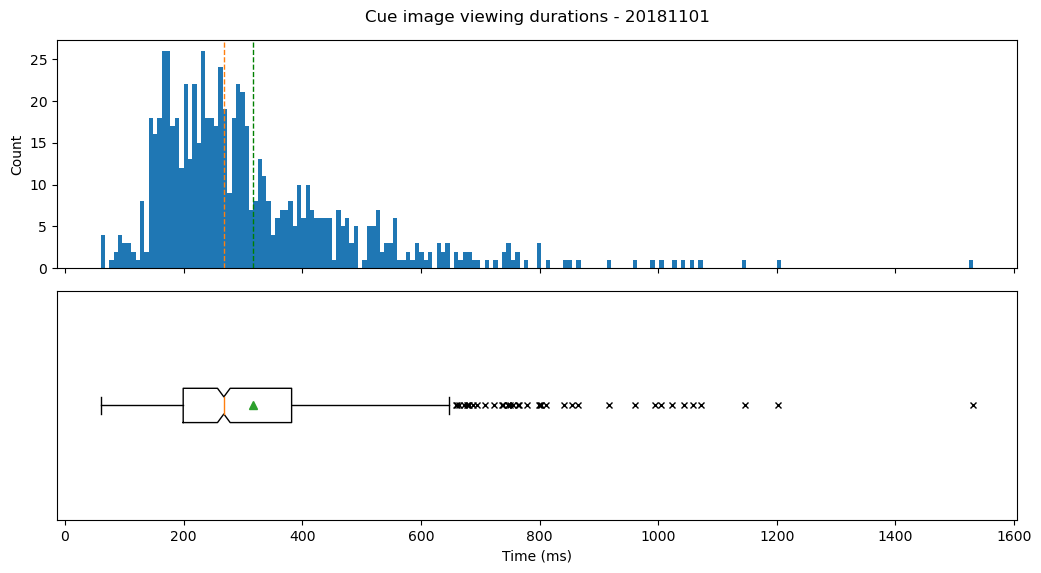

In [233]:
# Distribution of cue phase durations when the cue image was looked at
durs_cue = list()
for trial in cue_fixes_per_trial:
    for obs in trial:
        st_time, ed_time = obs
        durs_cue.append(1000*(ed_time-st_time))
durs_cue = np.array(durs_cue)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Cue image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_cue, bins=200)
axes[0].axvline(x=np.mean(durs_cue), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_cue), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_cue)

247.54057368215166

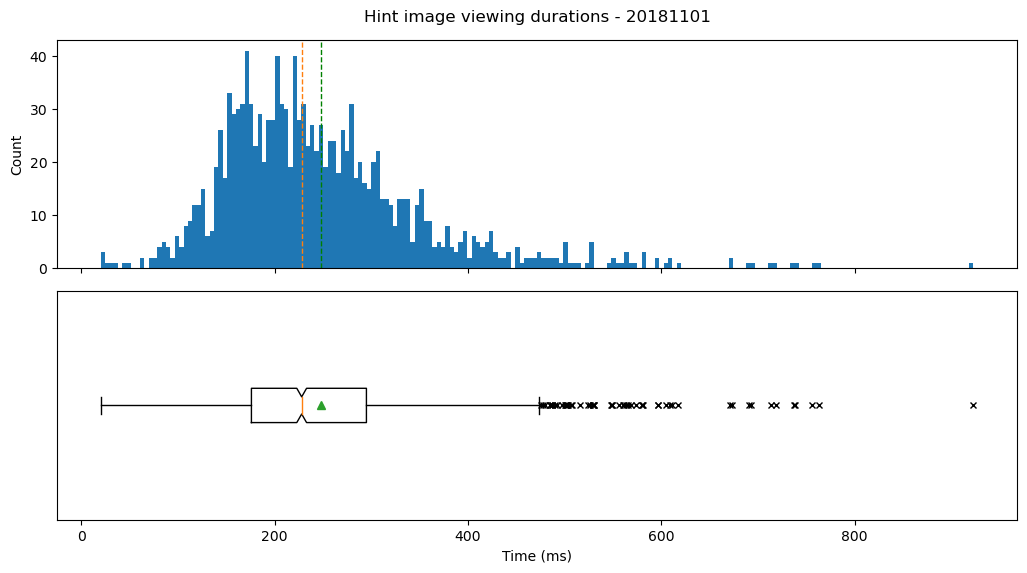

In [234]:
# Distribution of durations when the hint image was looked at
durs_hints = list()
for trial in hint_fixes_per_trial:
    for obs in trial:
        st_time, ed_time = obs
        durs_hints.append(1000*(ed_time-st_time))
durs_hints = np.array(durs_hints)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Hint image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_hints, bins=200)
axes[0].axvline(x=np.mean(durs_hints), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_hints), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_hints, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_hints)

251.11906142972

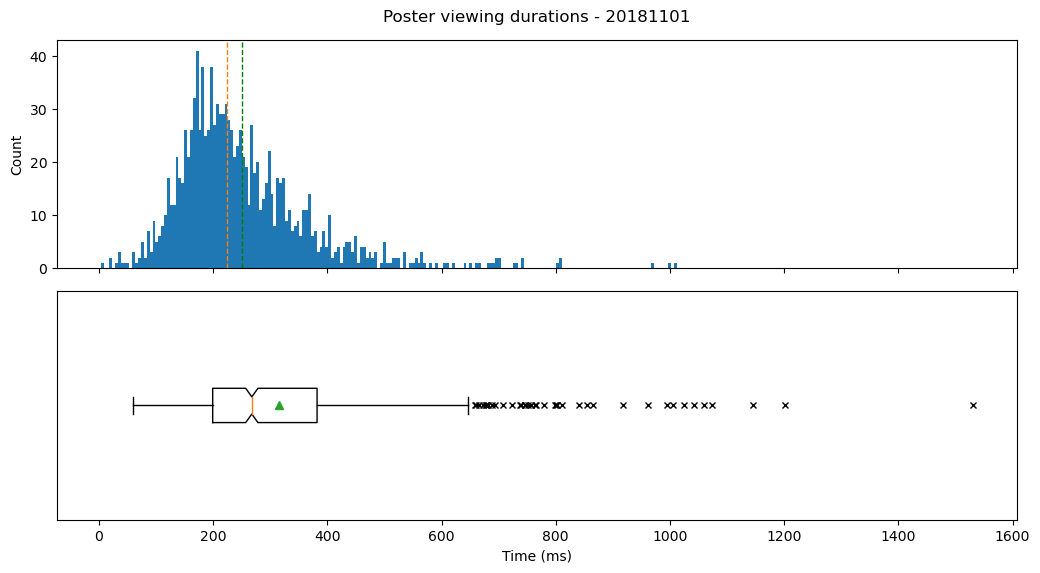

In [235]:
# Distribution of nav end durations when the poster was looked at
durs_navend = list()
for trial in poster_fixes_per_trial:
    for obs in trial:
        st_time, ed_time = obs
        durs_navend.append(1000*(ed_time-st_time))
durs_navend = np.array(durs_navend)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Poster viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_navend, bins=200)
axes[0].axvline(x=np.mean(durs_navend), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_navend), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_navend)

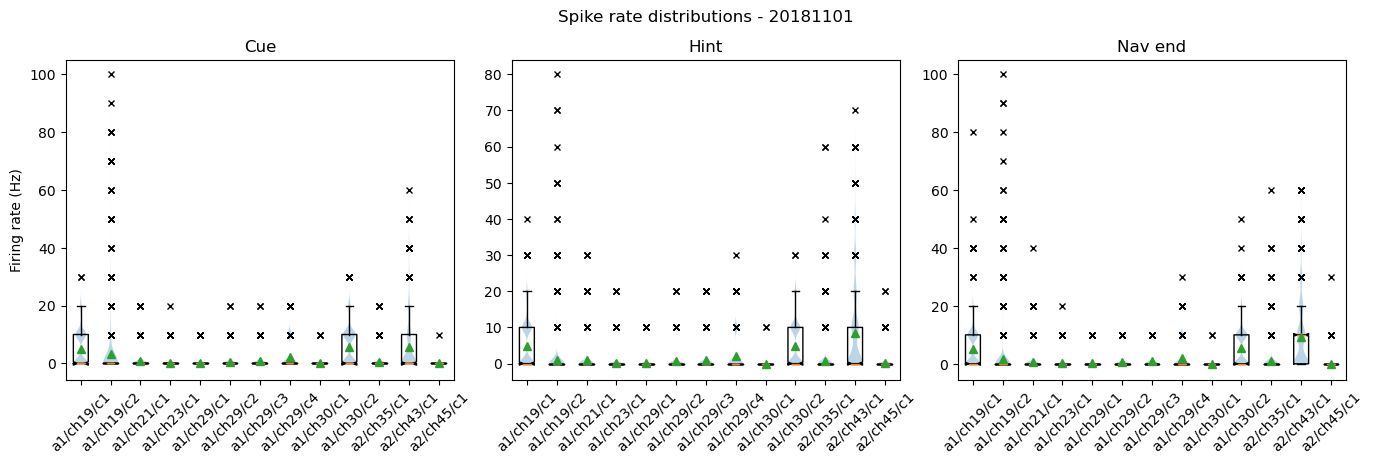

In [236]:
# Distribution of cue/hint/navend phase spike rates
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Spike rate distributions - {day_dir}', y=1.025)

axes[0].set_title('Cue')
axes[0].boxplot(spikerates_cue, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[0].violinplot(spikerates_cue, showextrema=False)
axes[0].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)
axes[0].set_ylabel('Firing rate (Hz)')

axes[1].set_title('Hint')
axes[1].boxplot(spikerates_hints, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[1].violinplot(spikerates_hints, showextrema=False)
axes[1].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

axes[2].set_title('Nav end')
axes[2].boxplot(spikerates_navend, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[2].violinplot(spikerates_navend, showextrema=False)
axes[2].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/firingrate_dist.png', bbox_inches='tight')

### Cue phase, goal response distances

In [237]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    # num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): np.empty((0, timeseries.shape[1])) for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)] = np.vstack([grouped[(goal1, goal2)], timeseries[idx,:]])
    return grouped

def euclidean_distance(arr1: np.array, arr2: np.array) -> float:
    return np.linalg.norm(arr1 - arr2)

def cosine_similarity(arr1: np.array, arr2: np.array) -> float:
    return np.nansum(np.multiply(arr1, arr2)) / (np.sqrt(np.nansum(np.multiply(arr1, arr1))) * np.sqrt(np.nansum(np.multiply(arr2, arr2))))

def pairwise_distances_between(clust1: np.array, clust2: np.array, metric=euclidean_distance) -> np.array:
    res = list()
    for obs1 in clust1:
        for obs2 in clust2:
            res.append(metric(obs1, obs2))
    return np.array(res)

def pairwise_distances_within(clust: np.array, metric=euclidean_distance) -> np.array:
    res = list()
    for i in range(clust.shape[0] - 1):
        for j in range(i+1, clust.shape[0]):
            obs1, obs2 = clust[i,:], clust[j,:]
            res.append(metric(obs1, obs2))
    return np.array(res)

def cohen_d(sample1: np.array, sample2: np.array) -> float:
    x1, x2 = np.mean(sample1), np.mean(sample2)
    s1, s2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = sample1.shape[0], sample2.shape[0]
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (x1 - x2) / s_pooled

In [238]:
# Group cue phase responses according to goal
spikerates_cue_per_goal = group_by_goal(spikerates_cue, goals_cue)

# Create 2D list to store results of all pairwise distances between goals
pairwise_distances_goal = [[np.array([]) for _ in range(num_goals)] for _ in range(num_goals)]
mean_distances_goal = np.empty((num_goals, num_goals))
for i in range(num_goals):
    for j in range(i, num_goals):
        group1, group2 = spikerates_cue_per_goal[i], spikerates_cue_per_goal[j]
        if i == j:
            distances = pairwise_distances_within(group1)
            pairwise_distances_goal[i][i] = distances
            mean_distances_goal[i,i] = np.mean(distances)
        else:
            distances = pairwise_distances_between(group1, group2)
            pairwise_distances_goal[i][j] = distances
            pairwise_distances_goal[j][i] = pairwise_distances_goal[i][j]
            mean_distances_goal[i,j] = np.mean(distances)
            mean_distances_goal[j,i] = mean_distances_goal[i,j]

# Peform Wilcoxon signrank tests to check for significant differences between distance distributions of each goal
# and compute effect sizes of differences between distance distributions of each goal
test_stats, p_vals, fx_sizes = np.empty((num_goals, num_goals)), np.empty((num_goals, num_goals)), np.empty((num_goals, num_goals))
for goal1 in range(num_goals):
    for goal2 in range(num_goals):
        if goal2 == goal1:
            test_stats[goal1][goal2] = np.nan
            p_vals[goal1][goal2] = np.nan
            fx_sizes[goal1][goal2] = np.nan
            continue

        test_stat, p_val = stats.mannwhitneyu(pairwise_distances_goal[goal1][goal2], pairwise_distances_goal[goal1][goal1])
        fx_size = cohen_d(pairwise_distances_goal[goal1][goal2], pairwise_distances_goal[goal1][goal1])

        test_stats[goal1][goal2] = test_stat
        p_vals[goal1][goal2] = p_val
        fx_sizes[goal1][goal2] = fx_size

In [239]:
# TR pillar goals vs all other goals
goal1, goal2 = 4, 5  # 1-indexed
pillar_TR_pairdists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_TR_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_TR_pairdists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_TR_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_TR_pairdists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_TR_labels.append((goal2, goal))

pillar_TR_meandists = np.array([mean_distances_goal[i-1,j-1] for i, j in pillar_TR_labels])
pillar_TR_tstats, pillar_TR_pvals, pillar_TR_fxs = np.empty_like(pillar_TR_meandists), np.empty_like(pillar_TR_meandists), np.empty_like(pillar_TR_meandists)
pillar_TR_tstats[:], pillar_TR_pvals[:], pillar_TR_fxs[:] = np.nan, np.nan, np.nan
for i, dist in enumerate(pillar_TR_pairdists[1:]):
    test_stat, p_val = stats.ranksums(dist, pillar_TR_pairdists[0])
    fx_size = cohen_d(dist, pillar_TR_pairdists[0])
    pillar_TR_tstats[i+1] = test_stat
    pillar_TR_pvals[i+1] = p_val
    pillar_TR_fxs[i+1] = fx_size


# BL pillar goals vs all other goals
goal1, goal2 = 1, 6  # 1-indexed
pillar_BL_pairdists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_BL_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_BL_pairdists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_BL_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_BL_pairdists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_BL_labels.append((goal2, goal))

pillar_BL_meandists = np.array([mean_distances_goal[i-1,j-1] for i, j in pillar_BL_labels])
pillar_BL_tstats, pillar_BL_pvals, pillar_BL_fxs = np.empty_like(pillar_BL_meandists), np.empty_like(pillar_BL_meandists), np.empty_like(pillar_BL_meandists)
pillar_BL_tstats[:], pillar_BL_pvals[:], pillar_BL_fxs[:] = np.nan, np.nan, np.nan
for i, dist in enumerate(pillar_BL_pairdists[1:]):
    test_stat, p_val = stats.ranksums(dist, pillar_BL_pairdists[0])
    fx_size = cohen_d(dist, pillar_BL_pairdists[0])
    pillar_BL_tstats[i+1] = test_stat
    pillar_BL_pvals[i+1] = p_val
    pillar_BL_fxs[i+1] = fx_size

In [240]:
# Apply PCA to cue phase spike rates for subsequent visualization
# For scree plot/cumulative explained variance
pca = PCA()
pca.fit(spikerates_cue)
pca_numcomps, pca_expvar = pca.n_components_, pca.explained_variance_ratio_

# For actual fitting to data, using 3 PCs
pca = PCA(n_components=3)
pcspikerates_cue = pca.fit_transform(spikerates_cue)

# Group cue phase responses according to goal
pcspikerates_cue_per_goal = group_by_goal(pcspikerates_cue, goals_cue)

# Group cue phase responses according to trajectory
# pcspikerates_cue_per_traj = group_by_trajectory(pcspikerates_cue, trajectories_cue)

# Group cue phase responses according to trajectory, then group by same start goal and same end goal
spikerates_cue_per_traj = group_by_trajectory(spikerates_cue, trajectories_cue)
spikerates_cue_start_goals, spikerates_cue_end_goals = [np.empty((0, num_cells)) for _ in range(num_goals)], [np.empty((0, num_cells)) for _ in range(num_goals)]
start_goals_labels, end_goals_labels = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
for traj, responses in spikerates_cue_per_traj.items():
    start_goal, end_goal = traj[0] - 1, traj[1] - 1
    spikerates_cue_start_goals[start_goal] = np.vstack([spikerates_cue_start_goals[start_goal], responses])
    start_goals_labels[start_goal].extend(responses.shape[0] * [end_goal + 1])
    spikerates_cue_end_goals[end_goal] = np.vstack([spikerates_cue_end_goals[end_goal], responses])
    end_goals_labels[end_goal].extend(responses.shape[0] * [start_goal + 1])

# Fit PCA within each group of same starting/same ending goal
pcspikerates_cue_start_goals, pcspikerates_cue_end_goals = list(), list()
for i in range(num_goals):
    pcspikerates_cue_start_goals.append(pca.fit_transform(spikerates_cue_start_goals[i]))
    pcspikerates_cue_end_goals.append(pca.fit_transform(spikerates_cue_end_goals[i]))

# Regroup into trajectories for plotting
pcspikerates_cue_per_traj = [[np.empty((0, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(pcspikerates_cue_start_goals[i]):
        k = start_goals_labels[i][j] - 1
        pcspikerates_cue_per_traj[i][k] = np.concatenate([pcspikerates_cue_per_traj[i][k], data.reshape(-1, 3)], axis=0)

Plots for response distances

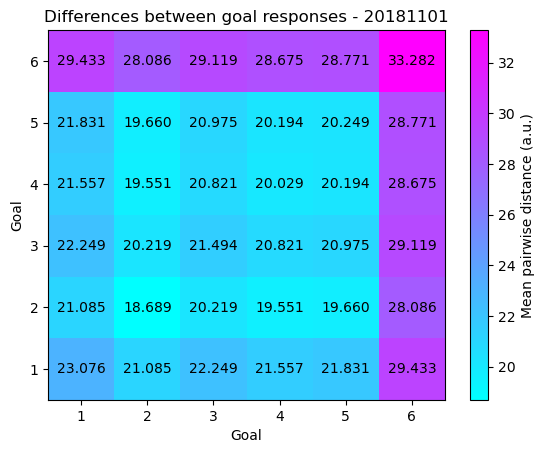

In [241]:
# Plot heatmap of mean distances
plt.figure()
ax = plt.gca()
plt.title(f'Differences between goal responses - {day_dir}')
plt.pcolormesh(mean_distances_goal, cmap='cool')
plt.colorbar(label='Mean pairwise distance (a.u.)')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.xlabel('Goal')
plt.ylabel('Goal')
for i, row in enumerate(mean_distances_goal):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.3f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_heatmap.png', bbox_inches='tight')

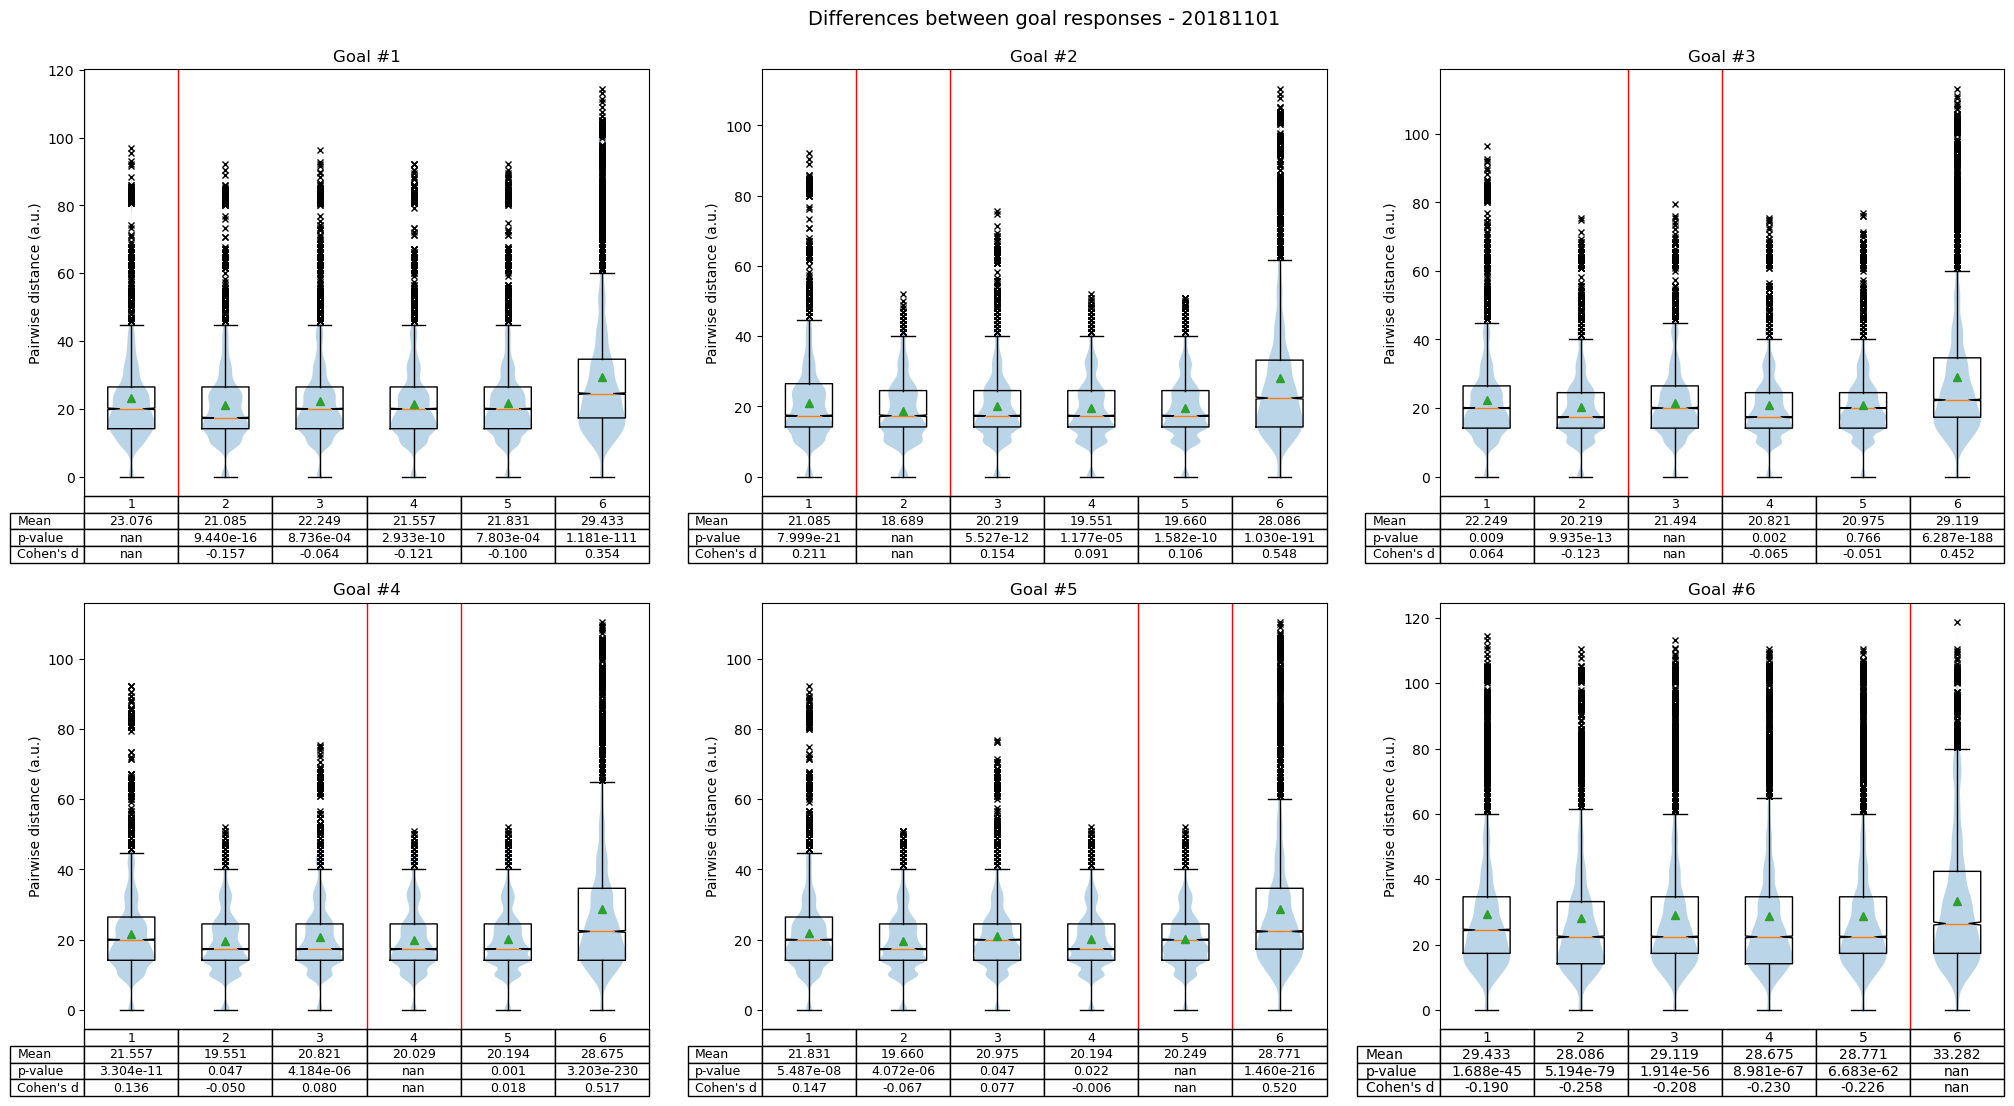

In [242]:
# Plot boxplot distribution of distances between one goal and the rest for all goals
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.25)
plt.suptitle(f'Differences between goal responses - {day_dir}', fontsize=14, y=0.95)

for goal in range(num_goals):
    ax = axes[goal//3, goal%3]
    ax.set_title(f'Goal #{goal+1}')
    ax.boxplot(pairwise_distances_goal[goal], showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
    ax.violinplot(pairwise_distances_goal[goal], showextrema=False)
    ax.table(cellText=[[f'{val:.3f}' for val in mean_distances_goal[goal,:]], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in p_vals[goal,:]], \
                       [f'{val:.3f}' for val in fx_sizes[goal,:]]], rowLabels=['Mean', 'p-value', 'Cohen\'s d'], colLabels=list(range(1, num_goals+1)), cellLoc='center')
    ax.axvline(x=goal+0.5, color='r', linewidth=1)
    ax.axvline(x=goal+1.5, color='r', linewidth=1)
    ax.set_xticks([])
    ax.set_ylabel('Pairwise distance (a.u.)')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_barplots.png', bbox_inches='tight')

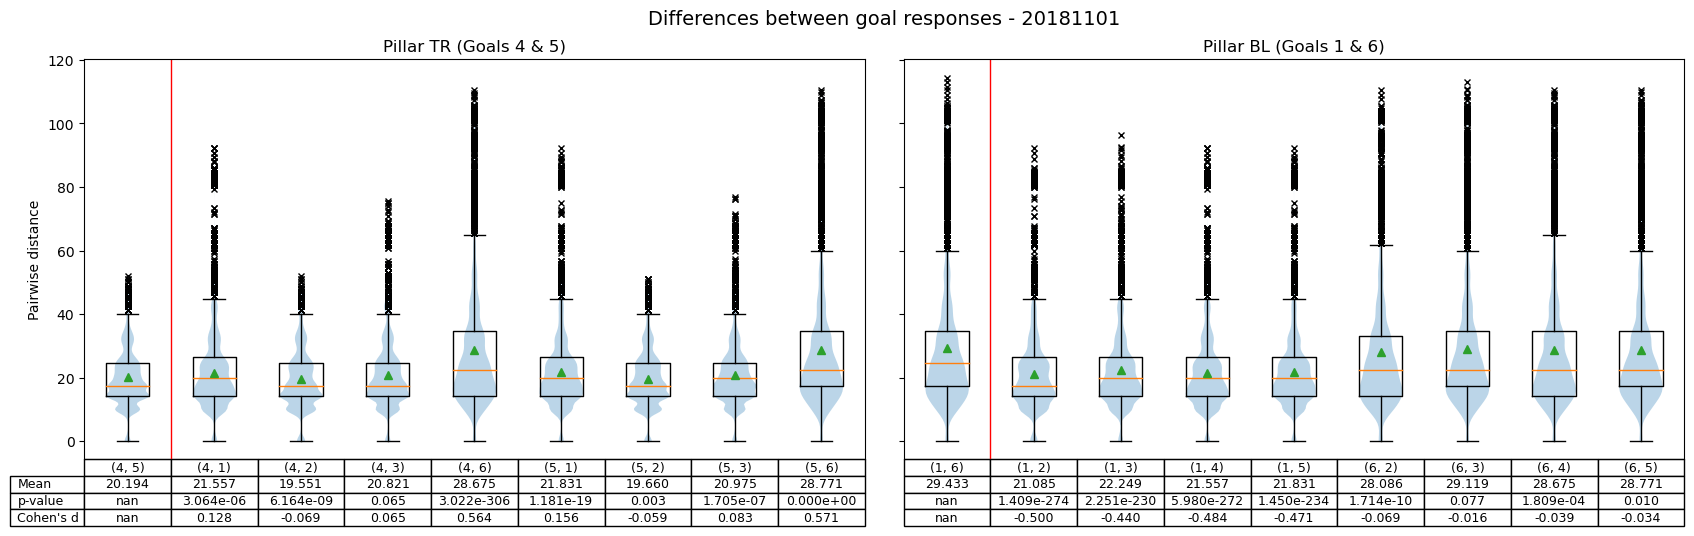

In [243]:
# Plot pairwise distance distributions between goals on TR/BL pillar and the rest
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.1)
plt.suptitle(f'Differences between goal responses - {day_dir}', fontsize=14, y=1)

axes[0].set_title('Pillar TR (Goals 4 & 5)')
axes[0].boxplot(pillar_TR_pairdists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
axes[0].violinplot(pillar_TR_pairdists, showextrema=False)
axes[0].axvline(x=1.5, color='r', linewidth=1)
axes[0].table(cellText=[[f'{val:.3f}' for val in pillar_TR_meandists], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in pillar_TR_pvals], \
                       [f'{val:.3f}' for val in pillar_TR_fxs]], rowLabels=['Mean', 'p-value', 'Cohen\'s d'], colLabels=pillar_TR_labels, cellLoc='center')
axes[0].set_xticks([])
axes[0].set_ylabel('Pairwise distance')

axes[1].set_title('Pillar BL (Goals 1 & 6)')
axes[1].boxplot(pillar_BL_pairdists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
axes[1].violinplot(pillar_BL_pairdists, showextrema=False)
axes[1].axvline(x=1.5, color='r', linewidth=1)
axes[1].table(cellText=[[f'{val:.3f}' for val in pillar_BL_meandists], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in pillar_BL_pvals], \
                       [f'{val:.3f}' for val in pillar_BL_fxs]], colLabels=pillar_BL_labels, cellLoc='center')
axes[1].set_xticks([])

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_barplots_pillars.png', bbox_inches='tight')

Text(0, 0.5, '% Variance Explained')

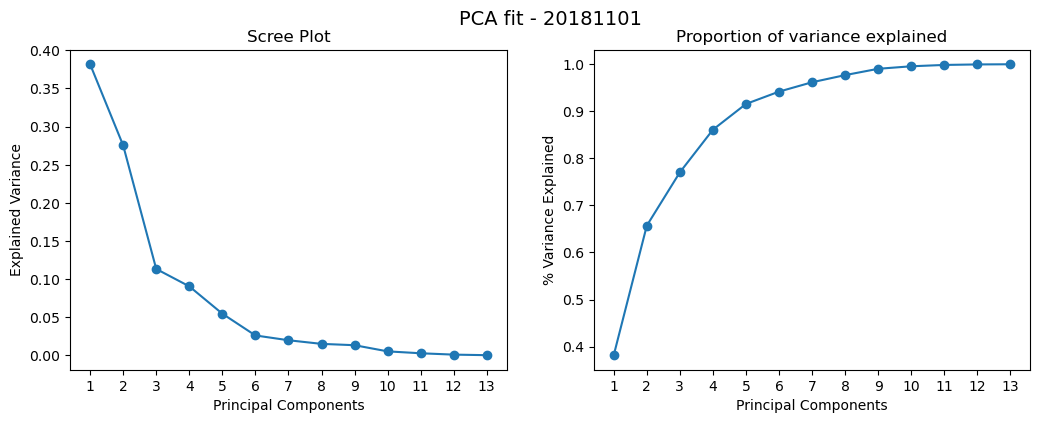

In [244]:
# PCA scree plot and cumulative explained variance for cue spike rates
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.1)
plt.suptitle(f'PCA fit - {day_dir}', fontsize=14, y=1)

axes[0].set_title('Scree Plot')
axes[0].plot(np.arange(pca_numcomps), pca_expvar, 'o-')
axes[0].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')

axes[1].set_title('Proportion of variance explained')
axes[1].plot(np.arange(pca_numcomps), np.cumsum(pca_expvar), 'o-')
axes[1].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('% Variance Explained')

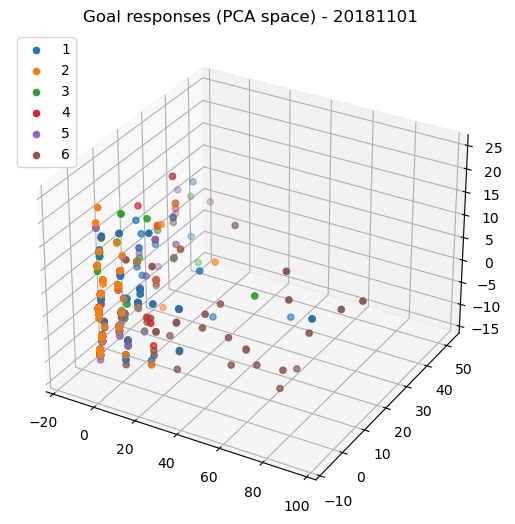

In [245]:
# Plot in PCA space for cue responses between different goals
fig = plt.figure()
ax = fig.gca()
ax.axis('off')
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.title(f'Goal responses (PCA space) - {day_dir}')
for i in range(num_goals):
    plot_data = pcspikerates_cue_per_goal[i]
    ax.scatter(plot_data[:,0], plot_data[:,1], plot_data[:,2], color=f'C{i}', label=i+1)
plt.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_all.png', bbox_inches='tight')

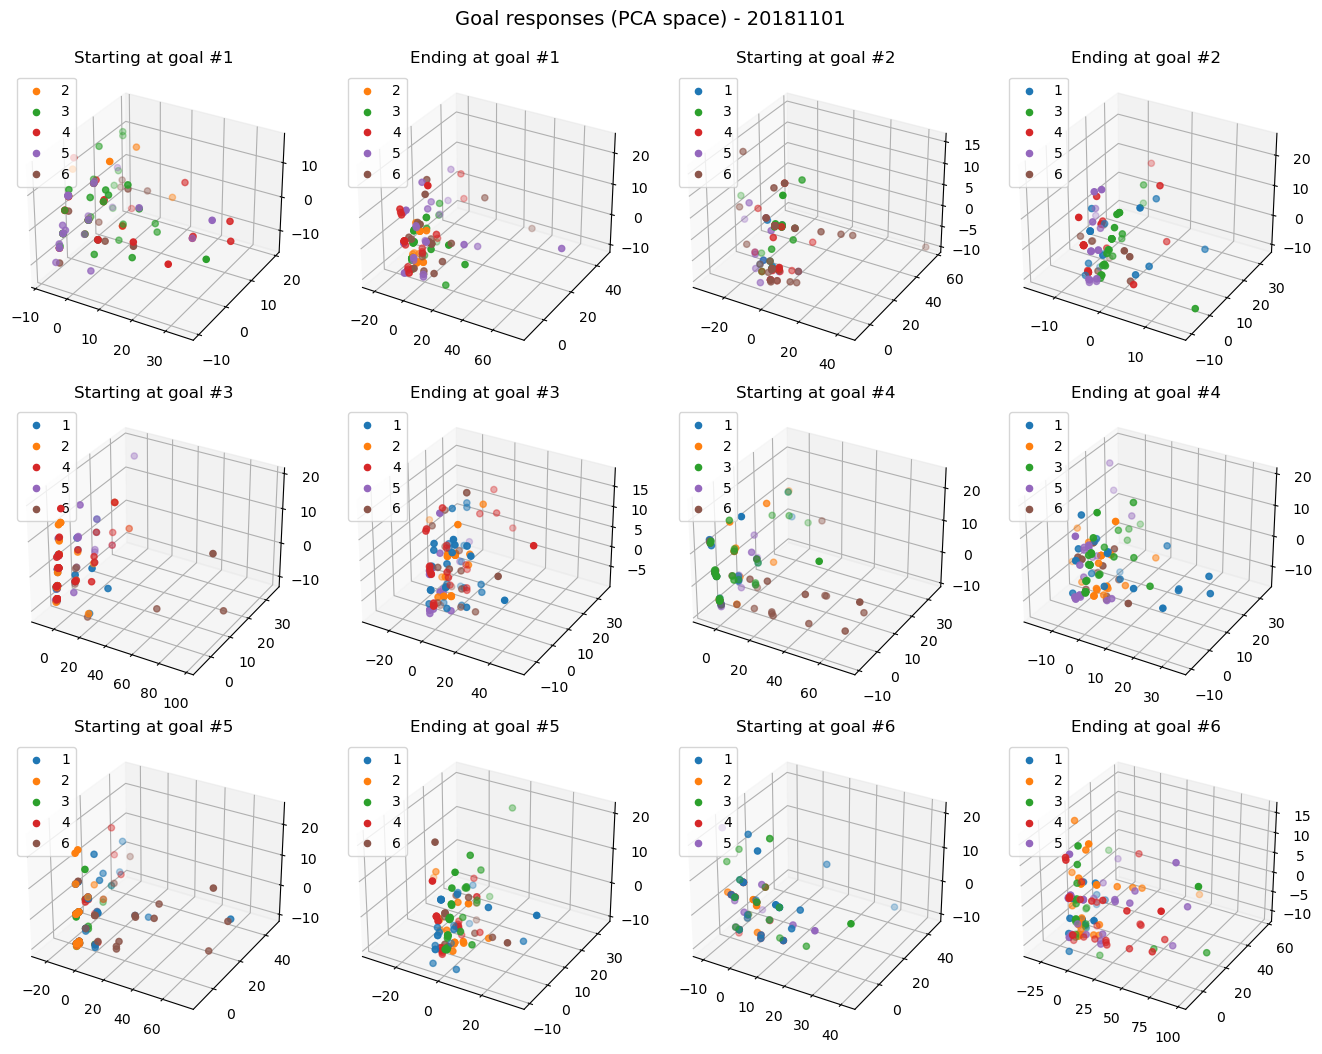

In [246]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

'''
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    plot_data, plot_labels = list(), list()
    for traj, responses in pcspikerates_cue_per_traj.items():
        if traj[0] == i+1:
            plot_data.append(responses)
            plot_labels.append(traj[1])
    for j, data in enumerate(plot_data):
        ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{plot_labels[j]-1}', label=plot_labels[j])
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    plot_data, plot_labels = list(), list()
    for traj, responses in pcspikerates_cue_per_traj.items():
        if traj[1] == i+1:
            plot_data.append(responses)
            plot_labels.append(traj[0])
    for j, data in enumerate(plot_data):
        ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{plot_labels[j]-1}', label=plot_labels[j])
    ax.legend(loc='upper left')
'''

for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj[i]):
        if data.shape[0] > 0:
            ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj[j][i]
        if data.shape[0] > 0:
            ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_trajectories.png', bbox_inches='tight')

### Cue/Hint/Navend phase, goal response decoding

In [247]:
class ResponseClassifier():
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, thresh):
        self.model.fit(X, y)
        self.thresh = thresh

    def set_thresh(self, thresh):
        self.thresh = thresh

    def predict(self, X):
        classes = self.model.predict(X)
        probs = self.model.predict_proba(X)
        filt = np.where(np.max(probs, axis=1) < self.thresh)
        classes[filt] = 0
        return classes


def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def confusion_matrix(y_pred: np.array, y_actl: np.array, num_classes: int) -> np.array:
    res = np.zeros((num_classes, num_classes), dtype=int)
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = int(pred - 1), int(actl - 1)
        res[pred, actl] += 1
    return res

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

In [248]:
# Build decoder for 6+1 classes
k_fold = 10
prob_mins = np.zeros(k_fold)
accuracy_cue = np.zeros(k_fold)
confusion_cue = np.zeros((num_goals, num_goals))
models = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_cue, goals_cue, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins[i] = np.min(y_pred_proba)
    accuracy_cue[i] = prediction_accuracy(y_pred, y_test)
    confusion_cue += confusion_matrix(y_pred, y_test, num_goals)
    models.append(lda)

prob_thresh = np.mean(prob_mins)
print(prob_thresh)

0.20039496399729467


In [249]:
# Fit models using each fold of data
confusion_hints, confusion_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_hints, accuracy_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models):
    models[i] = ResponseClassifier(model)
    models[i].set_thresh(prob_mins[i])

    # Prediction on hint viewing phases
    hints_preds = model.predict(spikerates_hints)
    confusion_hints += confusion_matrix(hints_preds, goals_hints, num_goals+1)
    accuracy_hints[i] = prediction_accuracy(hints_preds, goals_hints)

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend)
    confusion_navend += confusion_matrix(navend_preds, goals_navend, num_goals+1)
    accuracy_navend[i] = prediction_accuracy(navend_preds, goals_navend)

Plots for decoding

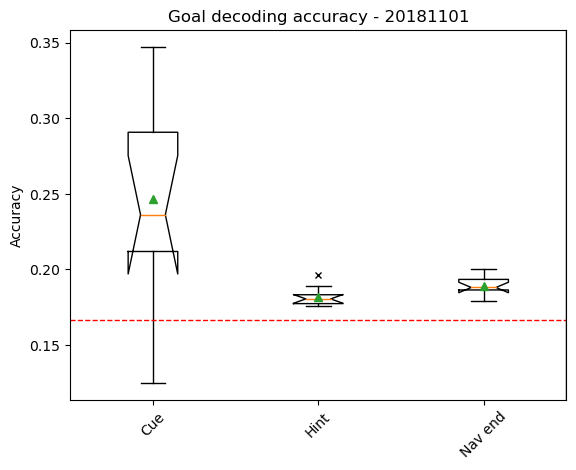

In [250]:
# Plot variance in prediciton accuracy between datasets
accuracies = {'Cue': accuracy_cue, 'Hint': accuracy_hints, 'Nav end': accuracy_navend}

plt.figure()
plt.title(f'Goal decoding accuracy - {day_dir}')
plt.boxplot(accuracies.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95208/1329008722.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


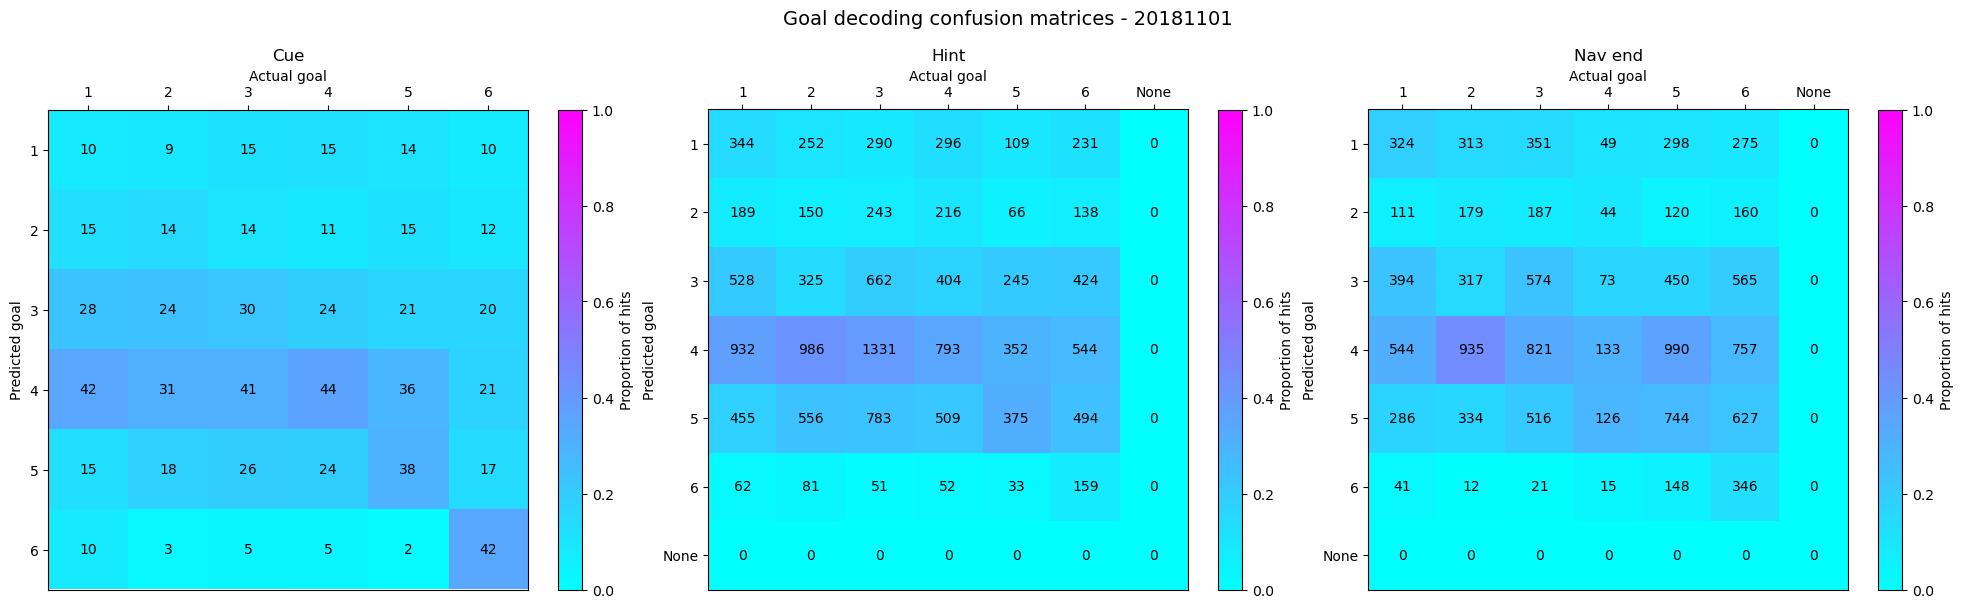

In [251]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Goal decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices = {'Cue': confusion_cue, 'Hint': confusion_hints, 'Nav end': confusion_navend}

for i, entry in enumerate(confusion_matrices.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/decoding_confusion.png', bbox_inches='tight')

### Save results to pkl file

In [252]:
# Package variables by analysis
raw_data = {'spikerates_cue': spikerates_cue, 'spikerates_hints': spikerates_hints, 'spikerates_navend': spikerates_navend,\
            'goals_cue': goals_cue, 'goals_hints': goals_hints, 'goals_navend': goals_navend,\
            'trajectories_cue': trajectories_cue, 'trajectories_hints': trajectories_hints, 'trajectories_navend': trajectories_navend}
goal_distances = {'pairwise_distances_goal': pairwise_distances_goal, 'mean_distances_goal': mean_distances_goal,\
                  'pcspikerates_cue_per_goal': pcspikerates_cue_per_goal, 'pcspikerates_cue_per_traj': pcspikerates_cue_per_traj,\
                  'test_stats': test_stats, 'p_vals': p_vals, 'fx_sizes': fx_sizes}
goal_decoding = {'models': models, 'accuracies': accuracies, 'confusion_matrices': confusion_matrices}
data = {'raw_data': raw_data, 'goal_distances': goal_distances, 'goal_decoding': goal_decoding}

# Save to pickle file
save_dir = f'data'
if not os.path.exists(datasave_dir):
    os.makedirs(datasave_dir)
with open(f'{datasave_dir}/{day_dir}_data.pkl', 'wb') as file:
    pickle.dump(data, file)